In [1]:
!pip install evaluate

In [2]:
! pip install -U accelerate
! pip install -U transformers

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
import pandas as pd

In [2]:
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile("/content/drive/MyDrive/For_Placement/SmartSenseDL.zip", 'r') as zObject:

    # Extracting all the members of the zip
    # into a specific location.
    zObject.extractall(
        path="/content/drive/MyDrive/For_Placement")

# Some critical Observations:

1. The judgement and summary files are sorted within the folders.
2. There is a one to one mapping from the judgement to summary files.
3. In the case of IN-Ext we will be going with the A1 summary.(Very likely A1 and A2 are the summaries produced by separate entities, thus we will be moving ahead with the one produced by A1)


# Exploratory Data Analysis

In [26]:
texts = []
count = []

temp=0
for file in os.listdir('/content/drive/MyDrive/For_Placement/dataset/IN-Abs/train-data/judgement/'):
    with open('/content/drive/MyDrive/For_Placement/dataset/IN-Abs/train-data/judgement/'+file, 'r') as f:
        texts.append(f.read())
    temp = temp + 1;

count.append(temp)


temp = 0
for file in os.listdir('/content/drive/MyDrive/For_Placement/dataset/IN-Ext/judgement/'):
    with open('/content/drive/MyDrive/For_Placement/dataset/IN-Ext/judgement/'+file, 'r') as f:
        texts.append(f.read())
    temp = temp + 1
count.append(temp)

temp = 0;
for file in os.listdir('/content/drive/MyDrive/For_Placement/dataset/UK-Abs/train-data/judgement/'):
    with open('/content/drive/MyDrive/For_Placement/dataset/UK-Abs/train-data/judgement/'+file, 'r') as f:
        texts.append(f.read())
    temp = temp + 1

count.append(temp)

summaries = []
count_summary = []

temp = 0;
for file in os.listdir('/content/drive/MyDrive/For_Placement/dataset/IN-Abs/train-data/summary/'):
    with open('/content/drive/MyDrive/For_Placement/dataset/IN-Abs/train-data/summary/'+file, 'r') as f:
        summaries.append(f.read())
    temp  = temp + 1;
count_summary.append(temp)
# We will use the A1 summary available(Not segment wise or A2)
temp = 0;
for file in os.listdir('/content/drive/MyDrive/For_Placement/dataset/IN-Ext/summary/full/A1/'):
    with open('/content/drive/MyDrive/For_Placement/dataset/IN-Ext/summary/full/A1/'+file, 'r') as f:
        summaries.append(f.read())
    temp = temp + 1
count_summary.append(temp)
temp = 0
for file in os.listdir('/content/drive/MyDrive/For_Placement/dataset/UK-Abs/train-data/summary/'):
    with open('/content/drive/MyDrive/For_Placement/dataset/UK-Abs/train-data/summary/'+file, 'r') as f:
        summaries.append(f.read())
    temp = temp + 1
count_summary.append(temp)

Text(0, 0.5, 'Number of summaires')

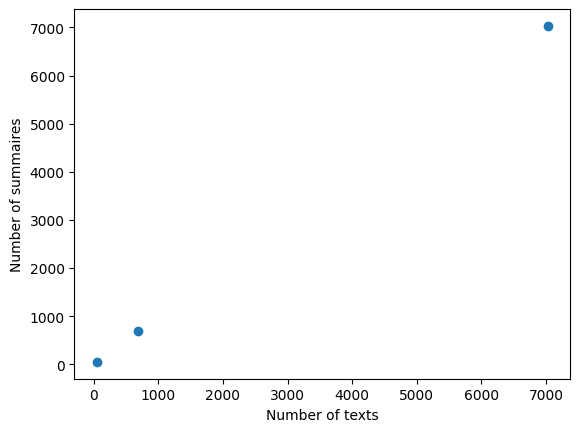

In [27]:
import matplotlib.pyplot as plt

x_ind = ["IN-Abs","IN-Ext","UK-Abs"]
plt.scatter(count_summary, count)
plt.xlabel('Number of texts')
plt.ylabel('Number of summaires')

Text(0, 0.5, 'Number of texts')

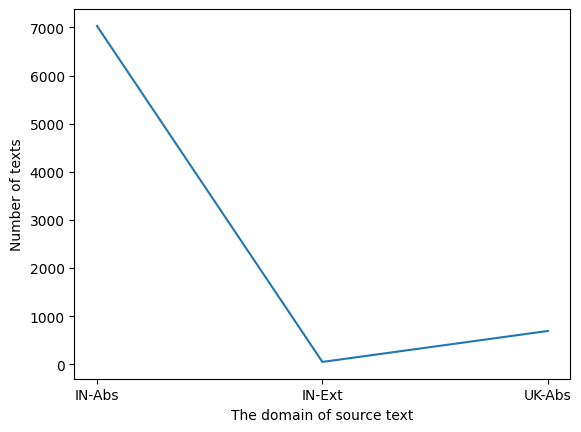

In [30]:
x_ind = ["IN-Abs","IN-Ext","UK-Abs"]
plt.plot(x_ind, count)
plt.xlabel('The domain of source text')
plt.ylabel('Number of texts')

In [65]:

df = pd.DataFrame({'text': texts, 'summary': summaries})
df = df.dropna(how='all')
df.head()

,text,summary
0,Appeal No. 198 of 1954.\nAppeal from the judgm...,The appellant was the Ruler of the State of Ba...
1,Appeal No. 285 of 1959.\nAppeal by Special Lea...,The appellant Corporation was assessed to sale...
2,Appeal No. 419 of 1958.\nAppeal by special lea...,The business of the respondent club was to run...
3,Appeal No. 650 of 1957.\nAppeal from the judgm...,The appellant who had agricultural income from...
4,Appeal No. 650 of 1957.\nAppeal from the judgm...,The appellant who had agricultural income from...


In [66]:
df.to_csv('/content/drive/MyDrive/For_Placement/dataset/cleaned_data.csv', index=False, escapechar='\\')

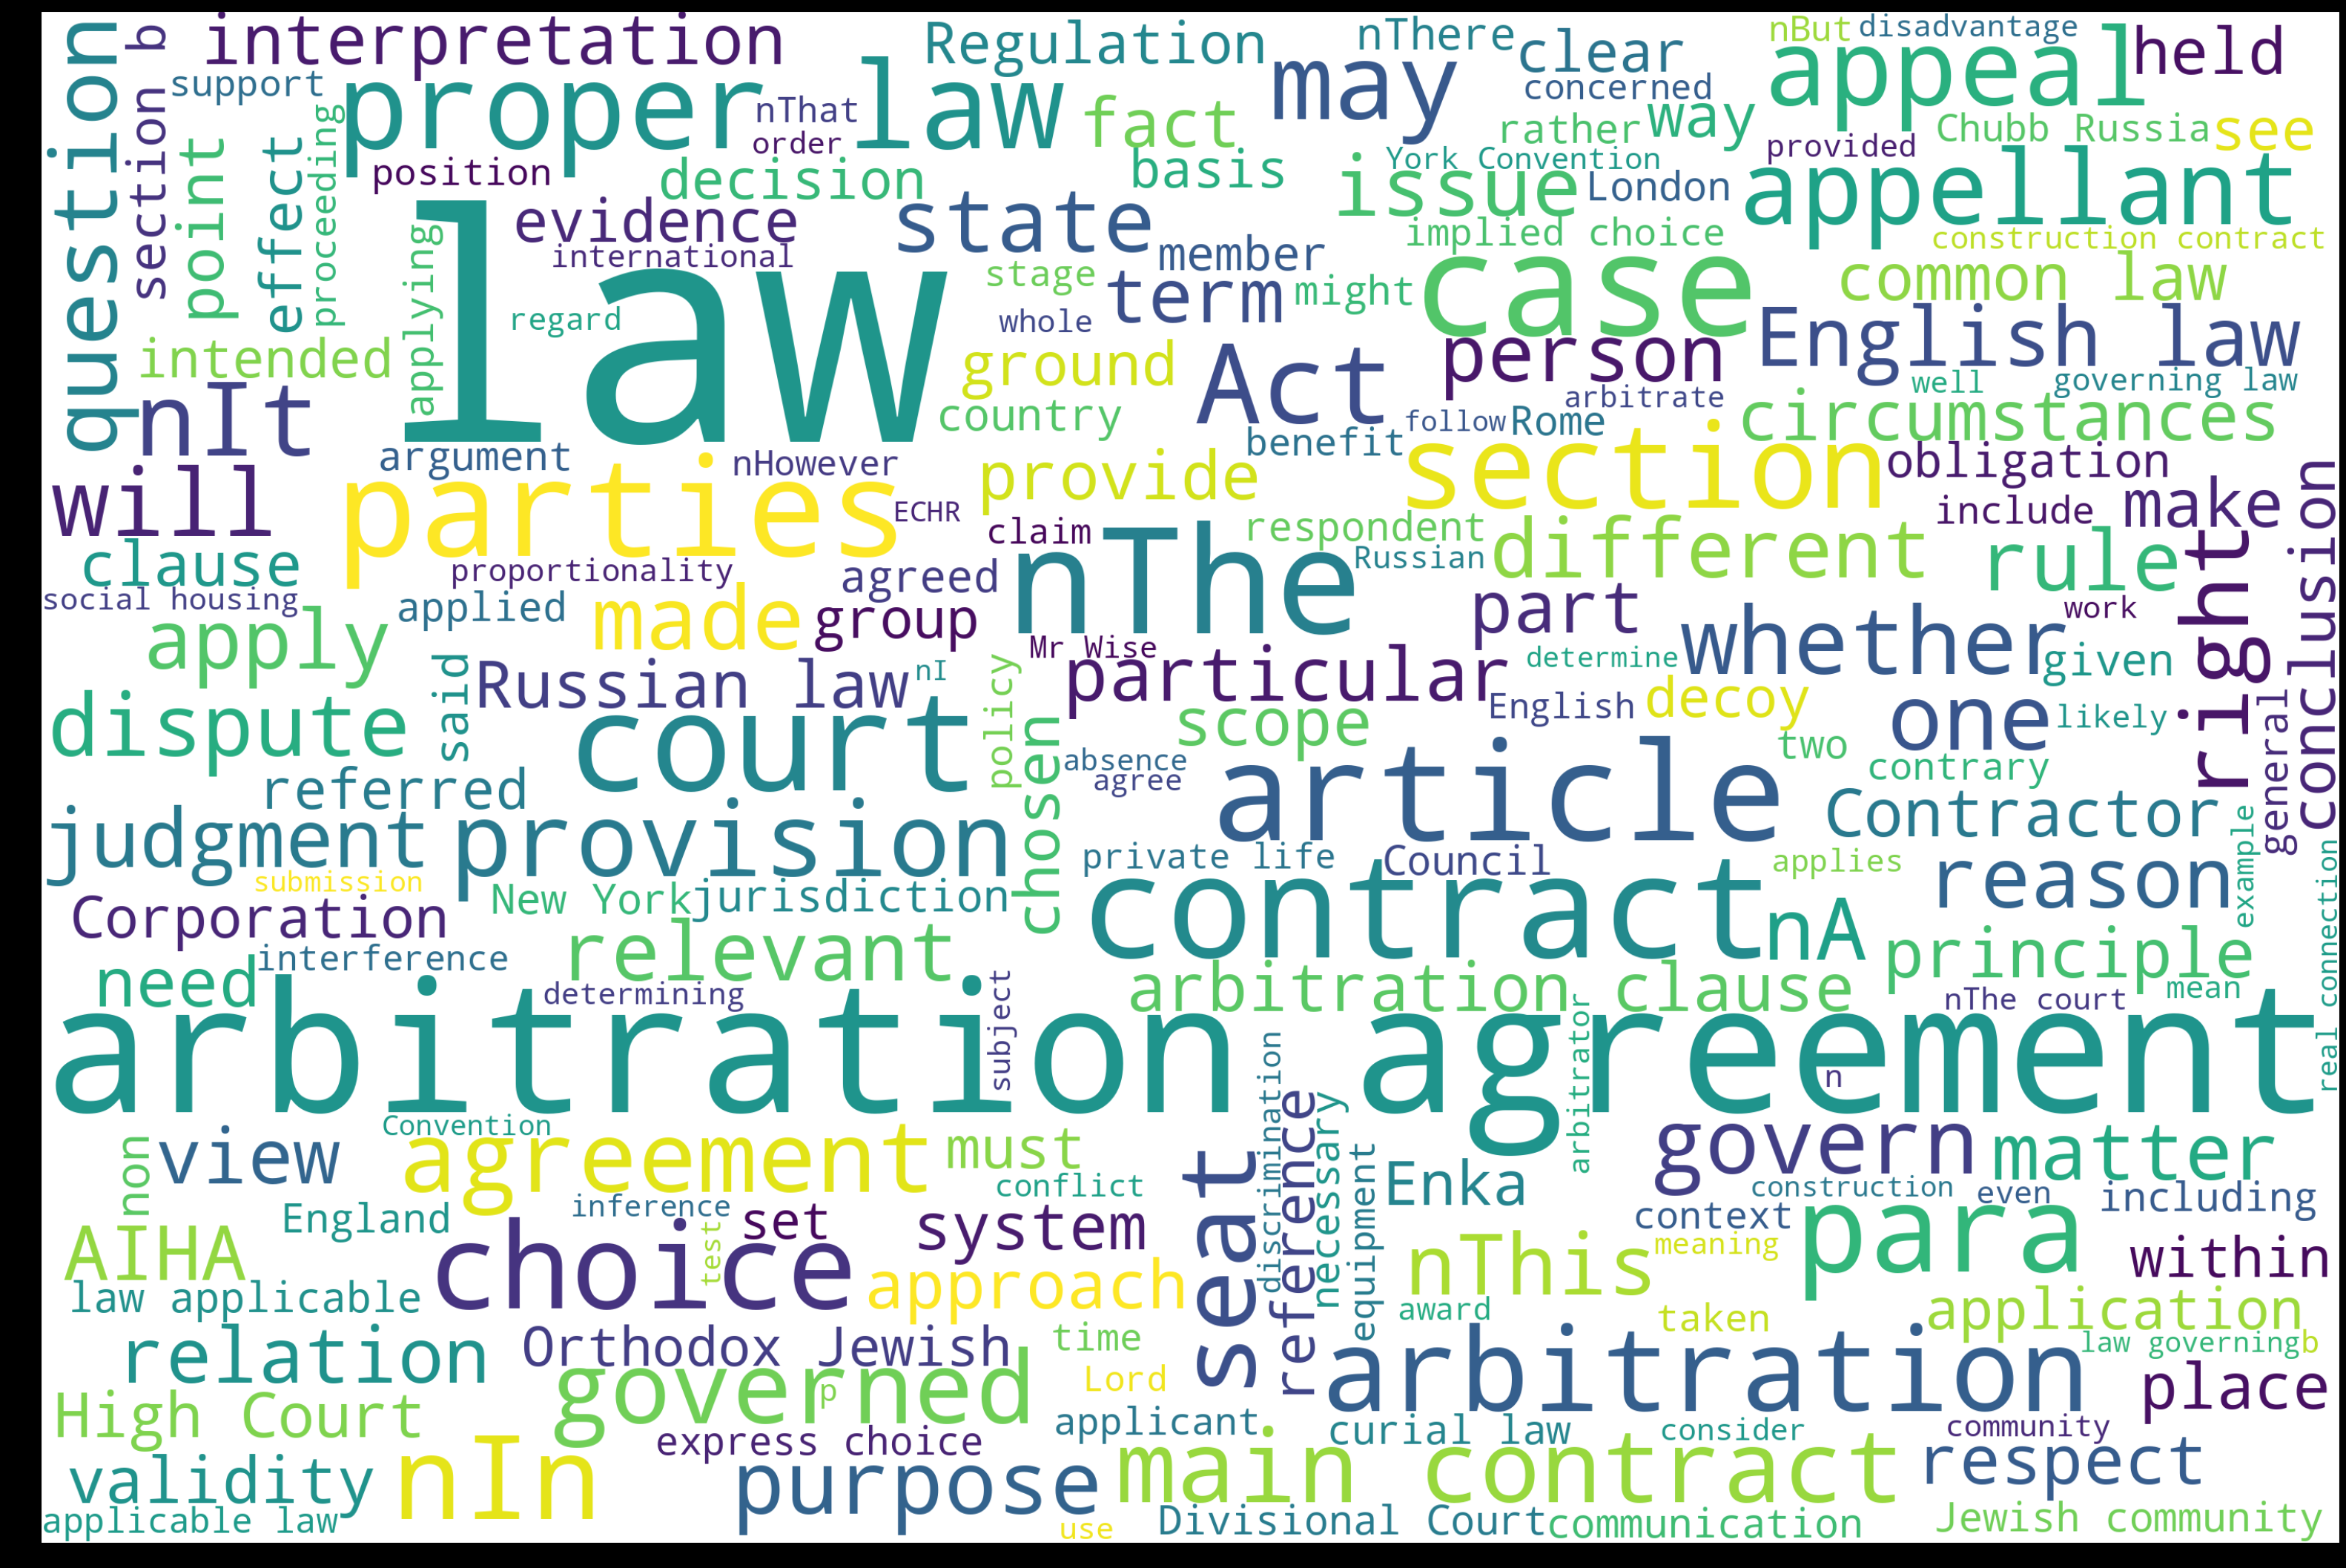

In [39]:
from wordcloud import WordCloud, STOPWORDS


# create word cloud

text = df['text'].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(text))

fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')

# Conclusion from EDA:
1. We have (text,summary) pair available from three domains.
2. There is imbalance in the number of datapoints in each of these domains.
3. Clearly IN-Abs has the most number of datapoints.
4. There is no disparity in the number of texts and their corresponding summaries.


In [67]:
from transformers import AutoTokenizer
from datasets import load_dataset

checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

dataset_file = '/content/drive/MyDrive/For_Placement/dataset/cleaned_data.csv'
dataset = load_dataset('csv', data_files=dataset_file, split='train')
dataset = dataset.train_test_split(test_size=0.1)
train_dataset = dataset['train']
val_dataset = dataset['test']


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [68]:
train_dataset

Dataset({
    features: ['text', 'summary'],
    num_rows: 6995
})

In [79]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('t5-small')

def tokenize(batch):
    tokenized_input = tokenizer(str(batch['text']), padding='max_length', truncation=True, max_length = 512)
    tokenized_label = tokenizer(str(batch['summary']), padding='max_length', truncation=True, max_length = 128)

    tokenized_input['labels'] = tokenized_label['input_ids']

    return tokenized_input

train_dataset = train_dataset.map(tokenize, batched=False)
val_dataset = val_dataset.map(tokenize, batched=False)

train_dataset.set_format('numpy', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format('numpy', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/6995 [00:00<?, ? examples/s]

Map:   0%|          | 0/778 [00:00<?, ? examples/s]

In [90]:
train_dataset.save_to_disk('/content/drive/MyDrive/For_Placement/new_data_train')
val_dataset.save_to_disk('/content/drive/MyDrive/For_Placement/new_data_test')

Saving the dataset (0/1 shards):   0%|          | 0/6995 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/778 [00:00<?, ? examples/s]

In [4]:
from datasets import Dataset
train_dataset =  Dataset.from_file("/content/drive/MyDrive/For_Placement/new_data_train/data-00000-of-00001.arrow")
val_dataset = Dataset.from_file("/content/drive/MyDrive/For_Placement/new_data_test/data-00000-of-00001.arrow")

In [5]:
import transformers
from transformers import T5ForConditionalGeneration, Trainer, TrainingArguments
import accelerate

model = T5ForConditionalGeneration.from_pretrained('t5-small')

output_dir = '/content/drive/MyDrive/For_Placement/output'

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_accumulation_steps=1,
    prediction_loss_only=True,
    learning_rate=0.001,
    evaluation_strategy='steps',
    save_steps=1000,
    save_total_limit=1,
    remove_unused_columns=True,
    logging_steps=1000,
    eval_steps=1000,
    logging_first_step=False,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    greater_is_better=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()
trainer.save_model(output_dir + '/model')

Step,Training Loss,Validation Loss
1000,2.565100,2.313720
2000,2.234800,2.244382
3000,2.079200,2.191483
4000,1.963500,2.177679


In [8]:
device = "cuda"
import torch
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('t5-small')

# Load model.bin

input_text = "Hello my name is Shruhrid!"

with torch.no_grad():
    tokenized_text = tokenizer(input_text, truncation=True, padding=True, return_tensors='pt')

    source_ids = tokenized_text['input_ids'].to(device, dtype = torch.long)
    source_mask = tokenized_text['attention_mask'].to(device, dtype = torch.long)

    generated_ids = model.generate(
        input_ids = source_ids,
        attention_mask = source_mask,
        max_length=512,
        num_beams=5,
        repetition_penalty=1,
        length_penalty=1,
        early_stopping=True,
        no_repeat_ngram_size=2
    )

    pred = tokenizer.decode(generated_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)

print("\noutput:\n" + pred)


output:
Hello my name is Shruhrid.
